In [143]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from pyLIMA.outputs import pyLIMA_plots
from cycler import cycler
import pandas as pd
sys.path.append(os.path.dirname(os.getcwd()))
from functions_roman_rubin import sim_fit,sim_event
from functions_roman_rubin import model_rubin_roman, fit_rubin_roman
from functions_roman_rubin import read_data, save


In [144]:

current_path = os.path.dirname(os.getcwd())
# print(current_path)
i=18 #select one event by its index in the TRILEGAL set
model='USBL'

path_TRILEGAL_set= current_path+'/TRILEGAL/PB_planet_split_1.csv'
path_to_save_model= current_path+'/test_sim_fit/'
path_to_save_fit= current_path+'/test_sim_fit/'
path_ephemerides= current_path+'/ephemerides/Gaia.txt'
path_dataslice = current_path+'/opsims/baseline/dataSlice.npy'
path_fit_rr = path_to_save_fit+f'/Event_RR_{i}_TRF.npy'
path_fit_roman =  path_to_save_fit+f'/Event_Roman_{i}_TRF.npy'
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}

## First we simulate the event 
The relevant code for this is the function sim_event(i, event_params, path_ephemerides, path_dataslice, model).

The output:

model(eg: pyLIMA.models.USBL_model.USBLmodel): the light curves, telescope name, etc.  
pyLIMA_parameters (dictionary): PyLIMA parameters.
decision (boolean): is made based on the detection criteria. This boolean is True if the event is a suitable candidate for fitting.

In [145]:
pd_planets = pd.read_csv(path_TRILEGAL_set)
event_params = pd_planets.iloc[int(i)]
my_own_model, pyLIMA_parameters, decision = sim_event(i, event_params, path_ephemerides, path_dataslice,model)

/home/anibal-pc/roman_rubin


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: 

Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
['third_caustic', [0, 0]]
A good event to fit


In [146]:
print('if the criterias are satisfied by this event we obtain "True":', decision)

if the criterias are satisfied by this event we obtain "True": True


In [147]:
if decision:
    print("Save the simulated event")
    save(i, path_TRILEGAL_set, path_to_save_model, my_own_model, pyLIMA_parameters)



Save the simulated event
Saving...
File saved: /home/anibal-pc/roman_rubin/test_sim_fit/Event_18.h5


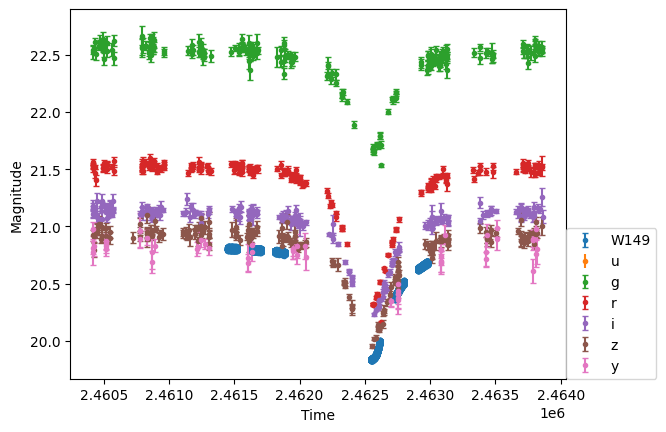

In [148]:
#plot without alignment

telescopes = my_own_model.event.telescopes

for telo in telescopes:
    plt.errorbar(telo.lightcurve_magnitude['time'],telo.lightcurve_magnitude['mag'],telo.lightcurve_magnitude['err_mag'],ls='',marker='.',capsize=2,label=telo.name)

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc=(1,0))
plt.gca().invert_yaxis
plt.show()

## Plot this event with pyLIMA

We can use the functionality of pyLIMA to make plot with aligned data in order to see the peak asociated to a planet of this particular event

Comment on pyLIMA:

To plot these events, since in our model we use the positions of Gaia with a shift in time,
it is necessary to modify the pyLIMA code as follows:

 In /pyLIMA/toolbox/fake_telescopes.py, we must add 'spacecraft_positions' to the list
 in the function:

 replicate_a_telescope(microlensing_model, telescope_index, light_curve_time=None,
                        astrometry_curve_time=None):

 attributes_to_copy = ['name', 'filter', 'location', 'ld_gamma', 'ld_sigma', 'ld_a1',
                       'ld_a2', 'ld_gamma1', 'ld_gamma2', 'location', 'spacecraft_name',
                       'spacecraft_positions', 'pixel_scale']



In [149]:
info_dataset, pyLIMA_parameters, bands = read_data(path_to_save_model+'/Event_18.h5')
ulens_params = []
PAR = ['t_center','u_center','tE','rho','separation','mass_ratio','alpha','piEN','piEE']

for b in (PAR):
    ulens_params.append(pyLIMA_parameters[b])
flux_params = []
for b in bands:
    if not len(bands[b])==0:
        zp_Rubin_to_pyLIMA = (10**((-27.4+ZP[b])/2.5))
        
        flux_params.append(pyLIMA_parameters['fsource_'+b]/zp_Rubin_to_pyLIMA)
        flux_params.append(pyLIMA_parameters['ftotal_'+b]/zp_Rubin_to_pyLIMA)
        
true_params = ulens_params+flux_params


In [150]:
model_ulens = 'USBL'

Source = 18
event_params = pyLIMA_parameters
event_params['te']=event_params['tE']
event_params['s']=event_params['separation']
event_params['q']=event_params['mass_ratio']

f= 'W149'
wfirst_lc = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'u'
lsst_u = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='g'
lsst_g = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='r'
lsst_r = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='i'
lsst_i = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_z = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_y = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T

model_true = model_rubin_roman(Source,True,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)


check_event  : Everything looks fine...


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS
Parallax(Full) estimated for the telescope g (Rubin): SUCCESS
Parallax(Full) estimated for the telescope r (Rubin): SUCCESS
Parallax(Full) estimated for the telescope i (Rubin): SUCCESS
Parallax(Full) estimated for the telescope z (Rubin): SUCCESS
Parallax(Full) estimated for the telescope y (Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 96 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA 

In [151]:

if len(true_params) != len(model_true.model_dictionnary):
    telescopes_fluxes = model_true.find_telescopes_fluxes(true_params)
    telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
                         telescopes_fluxes]#._fields]
    model_parameters3 = np.r_[true_params, telescopes_fluxes]
else:
    model_parameters3 = true_params


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 92359 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 92359 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 72585 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 72585 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 72585 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope g (Rubin): SUCCESS


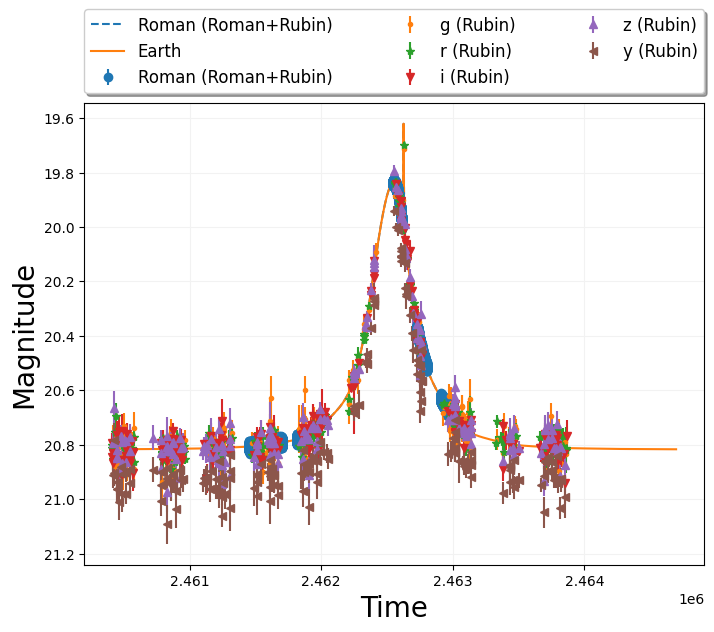

In [152]:
fig, axes = plt.subplots(1, 1,figsize=(8,6))

axes.set_ylabel("Magnitude",fontsize=20)
axes.set_xlabel("Time",fontsize=20)
axes.grid(True, color='0.95')
axes.invert_yaxis()
# axes.set_title('Simulated event')


pyLIMA_plots.plot_photometric_models(axes, model_true, true_params, plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes, model_true, true_params, plot_unit='Mag')
colors = ['darkslategray', 'gray', 'lightgray']

axes.legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()


# Fits

Relevant function fit_rubin_roman 

This function performs fitting of microlensing events using data from both the Rubin Observatory (LSST) and the Roman Space Telescope (WFIRST). It supports different microlensing models: Finite-Source Point Lens (FSPL), Uniform Source Binary Lens (USBL), and Point Source Point Lens (PSPL). The function also allows the use of different fitting algorithms, including TRF (Trust Region Reflective), MCMC (Markov Chain Monte Carlo), and DE (Differential Evolution).

In [153]:
algo='TRF'

Source = i
if decision:
    lc_to_fit = {}
    for telo in my_own_model.event.telescopes:
        if not len(telo.lightcurve_magnitude['mag'])==0:
            df = telo.lightcurve_magnitude.to_pandas()
            lc_to_fit[telo.name] = df.values
        else:
            lc_to_fit[telo.name] = []
    origin = my_own_model.origin
    fit_rr, event_fit_rr, pyLIMAmodel_rr = fit_rubin_roman(Source,event_params, path_to_save_fit, path_ephemerides,model,algo,origin,
                               lc_to_fit["W149"], lc_to_fit["u"], lc_to_fit["g"], lc_to_fit["r"],
                                           lc_to_fit["i"], lc_to_fit["z"],lc_to_fit["y"])
    fit_roman, event_fit_roman, pyLIMAmodel_roman = fit_rubin_roman(Source,event_params, path_to_save_fit, path_ephemerides,model,algo,origin,
                               lc_to_fit["W149"], [], [], [], [], [],[])


check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 25 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 25 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 25 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.95377491290438, 198.17008039184716, 115.85956729838873, 182.22793064946242, 166.46665663900635, 228.6265740239188, 198.9413151678031, 276.50461678243636, 218.25714149463693]
fit  : Trust Region Reflective fit SUCCESS
best_model: [2462548.2684595906, 0.23166391533638672, 445.56442813696003, 0.0001620994932991035, 0.9119518248542027, 0.0003087443093186362, 1.9685273881686651, -0.0029609792970738285, -0.012240053448344177, 186.45172612281132, 427.8100897948388, 35.08627607361698, 86.57299874310381, 140.88788907358767, 221.8093441858282, 127.1214061170674, 320.71644709371594, 160.2527822370197, 380.3684369578623, 182.25642152224404, 415.81603321401974] chi2 48962.23952696072
check_even

In [171]:
#we can make some tests to check if this is a good event before make the plot
from scipy.stats import chi2
chi2_roman = fit_roman.fit_results['chi2']
DOF_roman = len(pyLIMAmodel_roman.event.telescopes[0].lightcurve_magnitude['time'])-len(fit_roman.fit_results['best_model'])
print('Chi square reduced for Roman', chi2_roman/DOF_roman)
print('p-value of a chi squared test', chi2.sf(chi2_roman, DOF_roman))
print('We see a very low p-value this indicates that is unlikely that the model follow the data.')
# #metrics

#metric alpha
alpha_roman = abs(np.array(true_params[0:len(fit_roman.fit_results['best_model'])])-fit_roman.fit_results['best_model'])/np.array(true_params[0:len(fit_roman.fit_results['best_model'])]) 
alpha_rr = (abs(np.array(true_params[0:len(fit_rr.fit_results['best_model'])])-fit_rr.fit_results['best_model'])/np.array(true_params[0:len(fit_rr.fit_results['best_model'])]))[0:len(fit_roman.fit_results['best_model'])]
#metric beta
beta_roman = abs(np.array(true_params[0:len(fit_roman.fit_results['best_model'])])-fit_roman.fit_results['best_model'])/abs(np.sqrt(np.diag(fit_roman.fit_results['covariance_matrix'])))
beta_rr = (abs(np.array(true_params[0:len(fit_rr.fit_results['best_model'])])-fit_rr.fit_results['best_model'])/np.sqrt(np.diag(fit_rr.fit_results['covariance_matrix'])))[0:len(fit_roman.fit_results['best_model'])]
#metric gamma
gamma_roman = np.sqrt(np.diag(fit_roman.fit_results['covariance_matrix']))/np.array(true_params[0:len(fit_roman.fit_results['best_model'])])
gamma_rr = (np.sqrt(np.diag(fit_rr.fit_results['covariance_matrix']))/np.array(true_params[0:len(fit_rr.fit_results['best_model'])]))[0:len(fit_roman.fit_results['best_model'])]



Chi square reduced for Roman 1.1123148836991368
p-value of a chi squared test 2.540741837656348e-55
We see a very low p-value this indicates that is unlikely that the model follow the data.


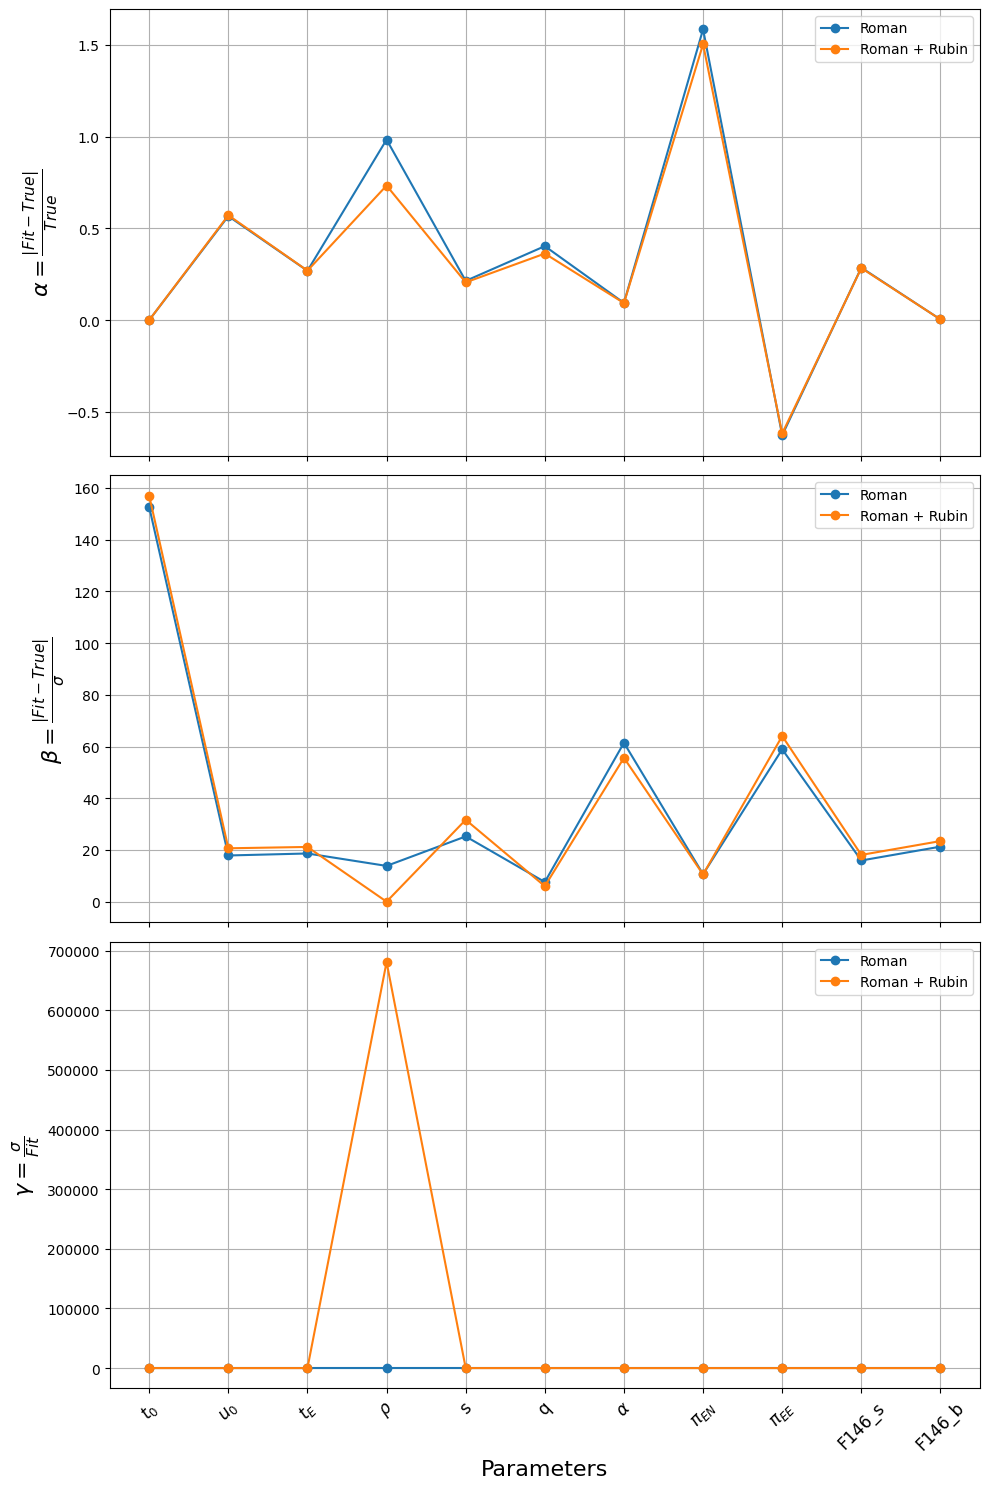

In [159]:

# Parameter labels
xticks = [r'$t_0$', r'$u_0$', r'$t_E$', r'$\rho$', 's', 'q', r'$\alpha$', r'$\pi_{EN}$', r'$\pi_{EE}$', 'F146_s', 'F146_b']

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot alpha
axs[0].plot(alpha_roman, marker='o', label='Roman')
axs[0].plot(alpha_rr, marker='o', label='Roman + Rubin')
axs[0].set_ylabel(r'$\alpha = \frac{|Fit-True|}{True}$', fontsize=16)
axs[0].legend()
axs[0].grid(True)

# Plot beta
axs[1].plot(beta_roman, marker='o', label='Roman')
axs[1].plot(beta_rr, marker='o', label='Roman + Rubin')
axs[1].set_ylabel(r'$\beta =\frac{|Fit-True|}{\sigma}$', fontsize=16)
axs[1].legend()
axs[1].grid(True)

# Plot gamma
axs[2].plot(gamma_roman, marker='o', label='Roman')
axs[2].plot(gamma_rr, marker='o', label='Roman + Rubin')
axs[2].set_ylabel(r'$\gamma =\frac{\sigma}{Fit}$', fontsize=16)
axs[2].legend()
axs[2].grid(True)

# Shared x-axis
plt.xticks(ticks=range(len(xticks)), labels=xticks, rotation=45, fontsize=12)
axs[2].set_xlabel('Parameters', fontsize=16)

plt.tight_layout()
plt.show()


## Plot fitted events

In [177]:
#use the fitted events

fits = [f for f in os.listdir(path_to_save_fit) if 'TRF' in f]
print(fits)

['Event_Roman_18_TRF.npy', 'Event_RR_18_TRF.npy']


In [160]:

# info_dataset, pyLIMA_parameters, bands = read_data(path_to_save_model+'/Event_18.h5')
data_fit_rr = np.load(path_to_save_fit+'Event_RR_18_TRF.npy',allow_pickle=True).item()
data_fit_roman = np.load(path_to_save_fit+'Event_Roman_18_TRF.npy',allow_pickle=True).item()


In [161]:

# {'t_center':data_fit_rr['best_model'][0]}
model_rr = model_rubin_roman(Source,False,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)
# {'t_center':data_fit_roman['best_model'][0]}
model_roman = model_rubin_roman(Source,False,event_params, path_ephemerides,model_ulens, wfirst_lc, [], [], [], [], [],[])


check_event  : Everything looks fine...


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning:

Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS
Parallax(Full) estimated for the telescope g (Rubin): SUCCESS
Parallax(Full) estimated for the telescope r (Rubin): SUCCESS
Parallax(Full) estimated for the telescope i (Rubin): SUCCESS
Parallax(Full) estimated for the telescope z (Rubin): SUCCESS
Parallax(Full) estimated for the telescope y (Rubin): SUCCESS
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman (Roman): SUCCESS


In [166]:
plt.close('all')
# custom_cycler = (cycler(color=custom_color))

# pyLIMA_plots.MARKERS_COLORS = custom_cycler
# pyLIMA_plots.MARKER_SYMBOLS = np.array([custom_marker])
### Find the telescope fluxes if needed

if len(data_fit_rr['best_model']) != len(model_rr.model_dictionnary):
    telescopes_fluxes = model_rr.find_telescopes_fluxes(data_fit_rr['best_model'])
    telescopes_fluxes = [telescopes_fluxes[key] for key in
                         telescopes_fluxes]#._fields]
    model_parameters1 = np.r_[data_fit_rr['best_model'], telescopes_fluxes]
else:
    model_parameters1 = data_fit_rr['best_model']

    
if len(data_fit_roman['best_model']) != len(model_roman.model_dictionnary):
    telescopes_fluxes = model_roman.find_telescopes_fluxes(data_fit_roman['best_model'])
    telescopes_fluxes = [telescopes_fluxes[key] for key in
                         telescopes_fluxes]#._fields]
    model_parameters2 = np.r_[data_fit_rr['best_model'], telescopes_fluxes]
else:
    model_parameters2 = data_fit_rr['best_model']


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 106466 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 106466 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 88418 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 88418 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 88418 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope g (Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 106491 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 106491 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman): SUCCESS
Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS
Parallax(Full) estimated for the telescope g (Rubin): SUCCESS


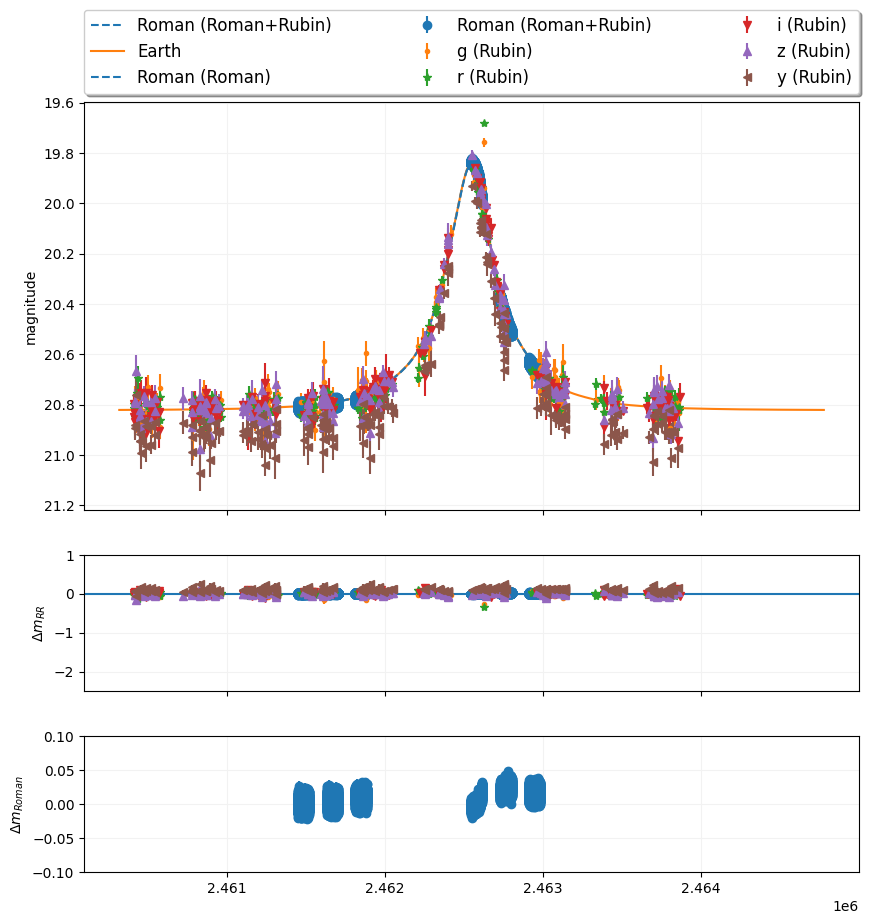

In [163]:
# tmin, tmax = 2460200., data_ogle[-1,0]+5.
# tmin, tmax = 2460160., data_ogle[-1,0]+20.

%matplotlib inline
fig, axes = plt.subplots(3, 1,figsize=(10,10), height_ratios=[3, 1,1], sharex=True)

# Lc plot
# axes[0].title.set_text('name')
axes[0].set_ylabel("magnitude") 
axes[0].grid(True, color='0.95')
axes[0].invert_yaxis()
# axes[0].set_xlim(tmin, tmax)
# axes[0].set_ylim(18.5, 12.5)
# axes[0].set_ylim(17.5, 12.5)

#Plot model1 and align data to it
pyLIMA_plots.plot_photometric_models(axes[0], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_photometric_models(axes[0], model_roman, data_fit_roman['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes[0], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
colors = ['darkslategray', 'gray', 'lightgray']

# for i in range(len(spec_jds)):
#     axes[0].axvline(x=spec_jds[i], label='Spec_'+str(i), ls='--', color=colors[i])

# plot residuals
axes[1].set_ylabel("$\Delta m_{RR} $") 
axes[1].grid(True, color='0.95')
axes[2].set_ylabel("$\Delta m_{Roman} $") 
axes[2].grid(True, color='0.95')

pyLIMA_plots.plot_residuals(axes[1], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_residuals(axes[2], model_roman, data_fit_roman['best_model'], plot_unit='Mag')
# axes[1].set_xlim(tmin, tmax)
axes[1].set_ylim(-2.5, 1)
axes[1].axhline(y=0)

# for i in range(len(spec_jds)):
#     axes[1].axvline(x=spec_jds[i], ls='--', color=colors[i])

axes[0].legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()
